## RSI (Índice de Força Relativa)

#### O RSI mede a força de uma tendência e a velocidade com que o preço de um ativo está se movendo

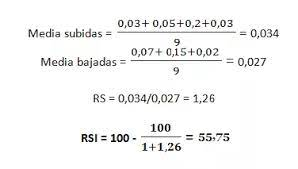 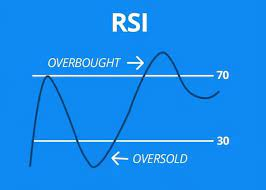

Quanto maior for a média de subidas comparada com a média de descidas, maior será o RSI, implicando que o mercado vem "gastando sua força"

In [40]:
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
import lightgbm as lgb
import joblib

In [2]:
df = pd.read_csv('Binance_ADAUSDT_1h.csv', skiprows=1)[:24 * 365]
df = df[::-1] # inverte o dataframe

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [4]:
df.drop(['Unix', 'Symbol'], axis=1, inplace=True)

c:\Python39\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


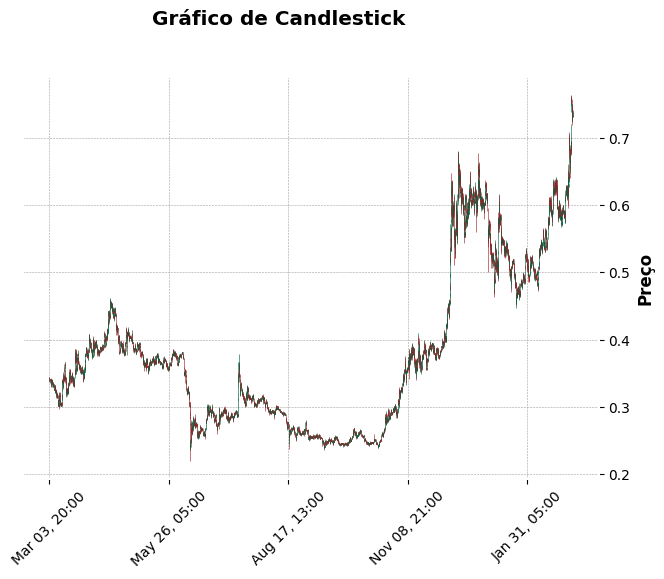

In [5]:
mpf.plot(df, type='candle', style='charles', title='Gráfico de Candlestick', ylabel='Preço')

In [6]:
close_percentual_variation = df['Close'] / df['Close'].shift(1) - 1

descent_delta = close_percentual_variation.clip(upper=0) * -1 # limite máximo é 0 e multiplica por -1 pois a soma daria negativa
rise_delta = close_percentual_variation.clip(lower=0) # limite mínimo é 0

In [7]:
periods = 15

# calcula a média das últimas 14 linhas (ex.: 1-21, 2-22, ...)
descent_delta_average = descent_delta.rolling(window=periods).mean()
rise_delta_average = rise_delta.rolling(window=periods).mean()

In [8]:
rs = rise_delta_average / descent_delta_average

rsi = 100 - 100 / (1 + rs)

df['RSI'] = rsi

c:\Python39\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


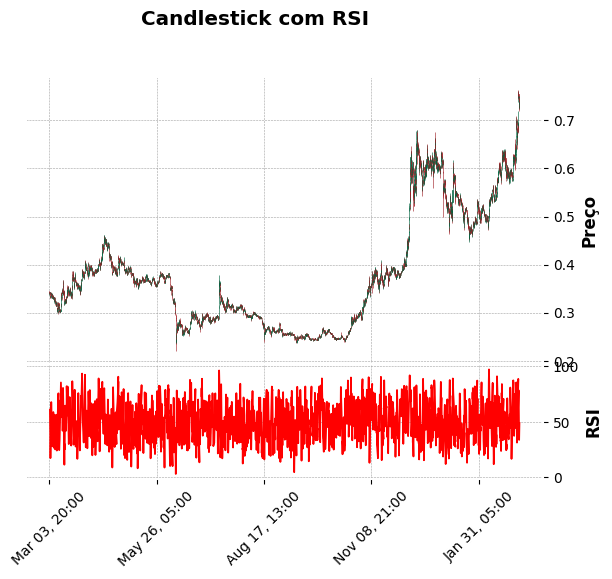

In [9]:
apdict = mpf.make_addplot(df['RSI'], panel=1, color='r', ylabel='RSI')

mpf.plot(df, type='candle', style='charles', addplot=apdict, figratio=(10,8), title='Candlestick com RSI', ylabel='Preço')

In [10]:
upper_limit = 70
lower_limit = 30

profit_short = 0
profit_long = 0
trades = [] # ('Buy', 'Short', close_price)
trades_to_show = [] # por ai coloca (nan, nan, nan) onde não tiver ação

def add_trade(trade, is_to_show):
  if not is_to_show:
    trades.append(trade)

  trades_to_show.append(trade)


for index, row in df.iterrows():
  if len(trades) !=0 and trades[-1][0] == 'Buy':
    position_type = trades[-1][1]

    if position_type == 'Long':
      if row['RSI'] >= upper_limit:
        profit_long += row['Close'] - trades[-1][2]

        add_trade(('Sell', 'Long', row['Close']), 0)        
      else:
        add_trade((np.nan, np.nan, np.nan), 1)
    else:
      if row['RSI'] <= lower_limit:
        profit_short += trades[-1][2] - row['Close']

        add_trade(('Sell', 'Short', row['Close']), 0)
      else:
        add_trade((np.nan, np.nan, np.nan), 1)
  else: # 'Sell' ou ainda não fez nada
    if row['RSI'] >= upper_limit:
      add_trade(('Buy', 'Short', row['Close']), 0)
    elif row['RSI'] <= lower_limit:
      add_trade(('Buy', 'Long', row['Close']), 0)
    else:
      add_trade((np.nan, np.nan, np.nan), 1)

In [11]:
profit_short, profit_long

(-0.10880000000000015, 0.0920999999999999)

In [12]:
trades_to_show_df = pd.DataFrame(trades_to_show, columns=['Action', 'Position', 'Price'])

In [13]:
long_entries = []
long_exits = []
short_entries = []
short_exits = []

for _, row in trades_to_show_df.iterrows():
  if np.isnan(row['Price']):
    long_entries.append(np.nan)
    long_exits.append(np.nan)
    short_entries.append(np.nan)
    short_exits.append(np.nan)
  else:
    long_entries.append(row['Price'] if row['Action'] == 'Buy' and row['Position'] == 'Long' else np.nan)
    long_exits.append(row['Price'] if row['Action'] == 'Sell' and row['Position'] == 'Long' else np.nan)
    short_entries.append(row['Price'] if row['Action'] == 'Buy' and row['Position'] == 'Short' else np.nan)
    short_exits.append(row['Price'] if row['Action'] == 'Sell' and row['Position'] == 'Short' else np.nan)

c:\Python39\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


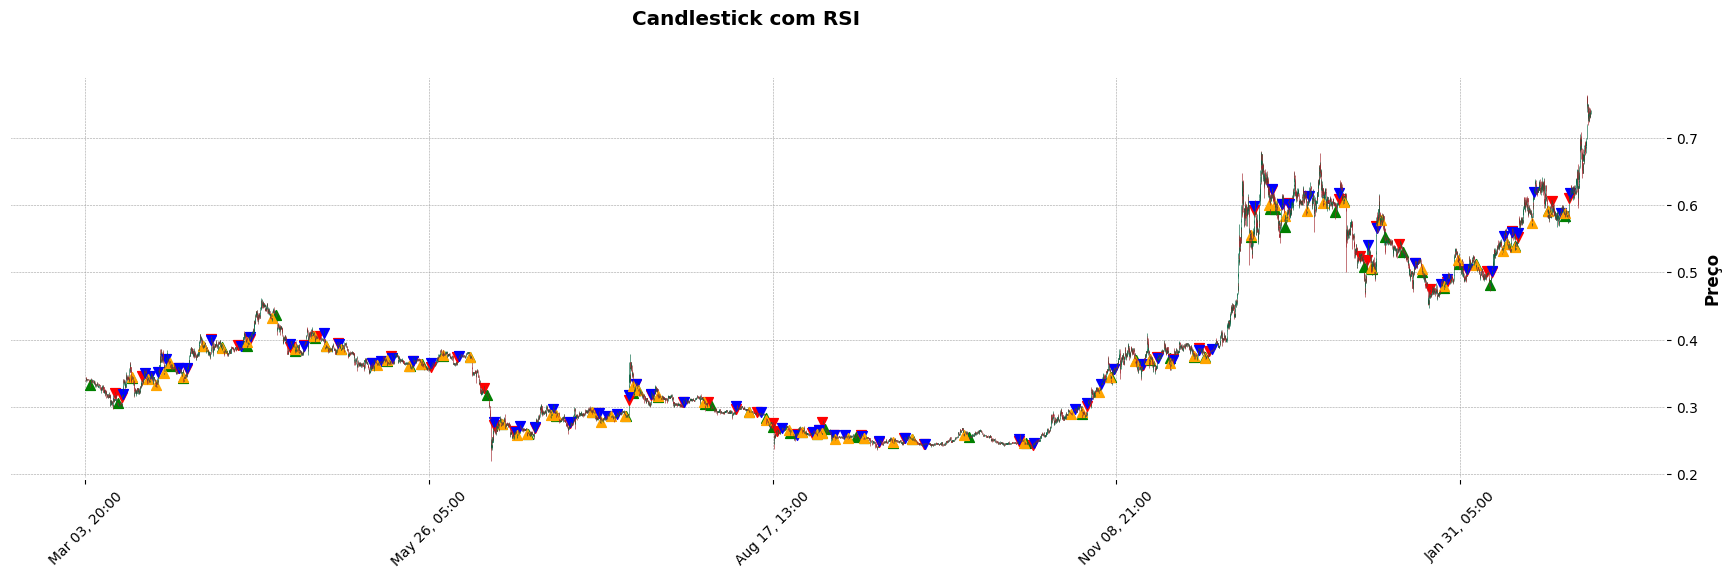

In [14]:

apds = [
  mpf.make_addplot(long_entries, type='scatter', markersize=50, marker='^', color='green'),
  mpf.make_addplot(long_exits, type='scatter', markersize=50, marker='v', color='red'),
  mpf.make_addplot(short_entries, type='scatter', markersize=50, marker='v', color='blue'),
  mpf.make_addplot(short_exits, type='scatter', markersize=50, marker='^', color='orange')
]

mpf.plot(df, type='candle', style='charles', addplot=apds, figratio=(32,8), title='Candlestick com RSI', ylabel='Preço')

## Bandas de Bollinger

In [15]:
# Calculate the 20-period Simple Moving Average (SMA)
df['SMA'] = df['Close'].rolling(window=periods).mean()

# Calculate the 20-period Standard Deviation (SD)
df['SD'] = df['Close'].rolling(window=periods).std()

# Calculate the Upper Bollinger Band (UB) and Lower Bollinger Band (LB)
df['UB'] = df['SMA'] + 2 * df['SD']
df['LB'] = df['SMA'] - 2 * df['SD']

c:\Python39\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


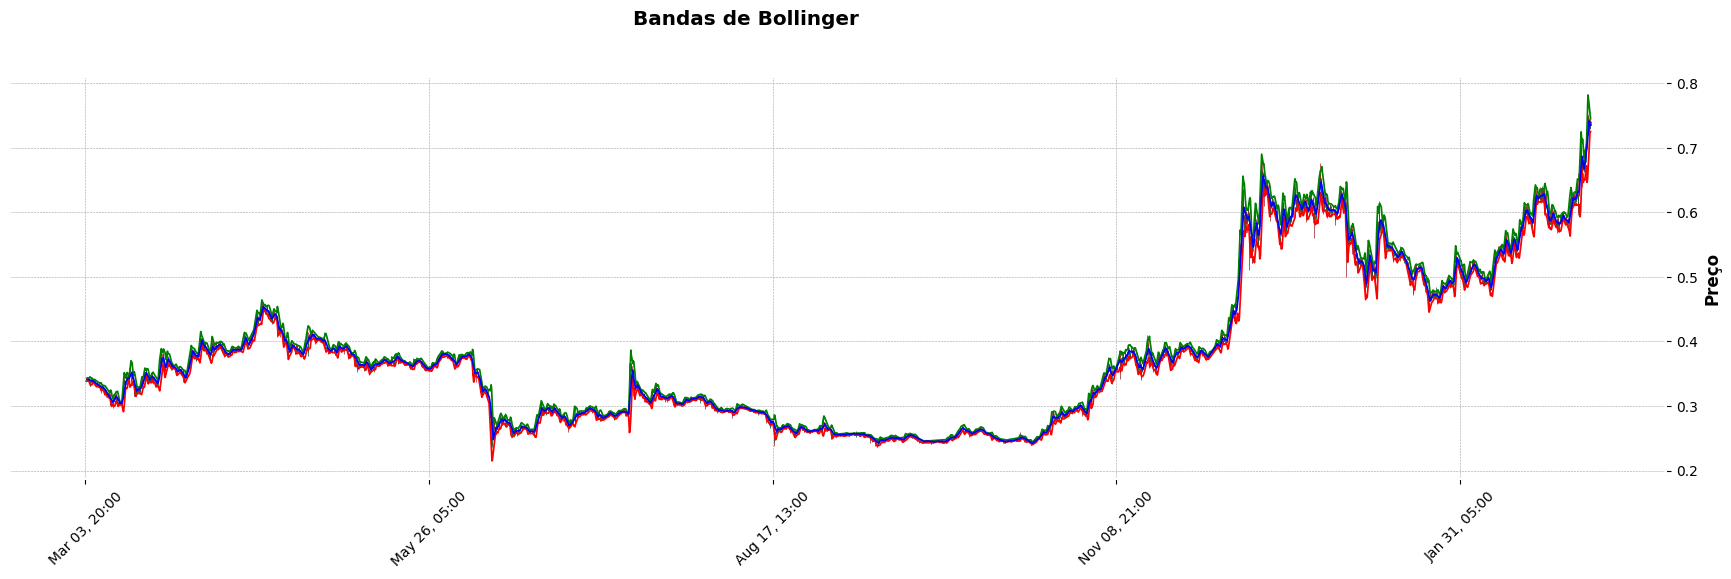

In [16]:

apds = [
  mpf.make_addplot(df['UB'], color='green'),
  mpf.make_addplot(df['LB'], color='red'),
  mpf.make_addplot(df['SMA'], color='blue'),
]

mpf.plot(df, style='charles', addplot=apds, figratio=(32,8), title='Bandas de Bollinger', ylabel='Preço')

## MACD

In [17]:
# Parâmetros para o MACD
short_window = 12  # Janela para a média móvel rápida (EMA)
long_window = 26   # Janela para a média móvel lenta (EMA)
signal_window = 9  # Janela para o sinal de EMA do MACD

# Calculando a média móvel exponencial rápida e lenta
df['EMA_fast'] = df['Close'].ewm(span=short_window, adjust=False).mean()
df['EMA_slow'] = df['Close'].ewm(span=long_window, adjust=False).mean()

# Calculando o MACD
df['MACD'] = df['EMA_fast'] - df['EMA_slow']

# Calculando a linha de sinal do MACD
df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

c:\Python39\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


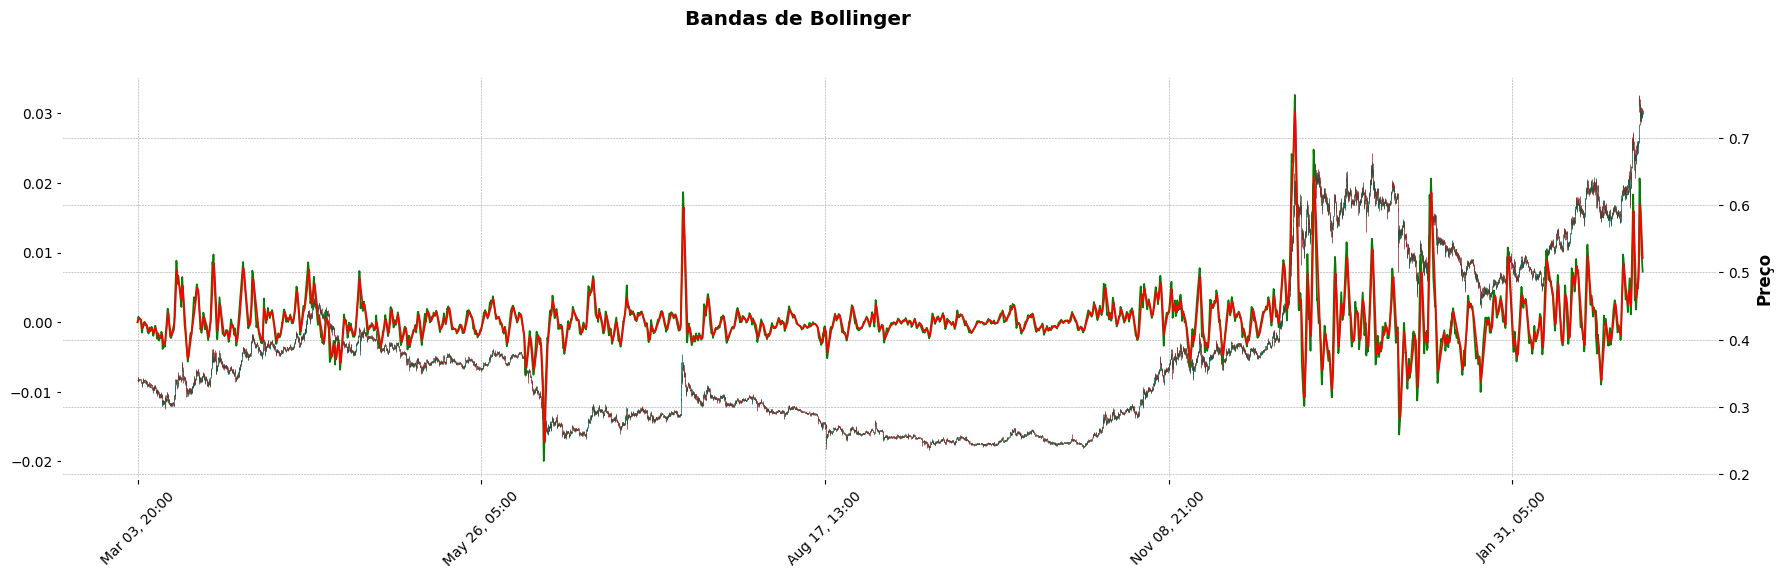

In [18]:

apds = [
  mpf.make_addplot(df['MACD'], color='green'),
  mpf.make_addplot(df['Signal_Line'], color='red'),
]

mpf.plot(df, style='charles', addplot=apds, figratio=(32,8), title='Bandas de Bollinger', ylabel='Preço')

## ATR

In [19]:
# Calculando a faixa verdadeira (True Range - TR)
df['High_Low'] = df['High'] - df['Low']
df['High_Close'] = abs(df['High'] - df['Close'].shift())
df['Low_Close'] = abs(df['Low'] - df['Close'].shift())
df['TR'] = df[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)

# Calculando o ATR (Average True Range)
period = 14  # Período comum para o ATR
df['ATR'] = df['TR'].rolling(window=period).mean()

# Limpando as colunas intermediárias, se desejado
df.drop(['High_Low', 'High_Close', 'Low_Close', 'TR'], axis=1, inplace=True)

c:\Python39\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


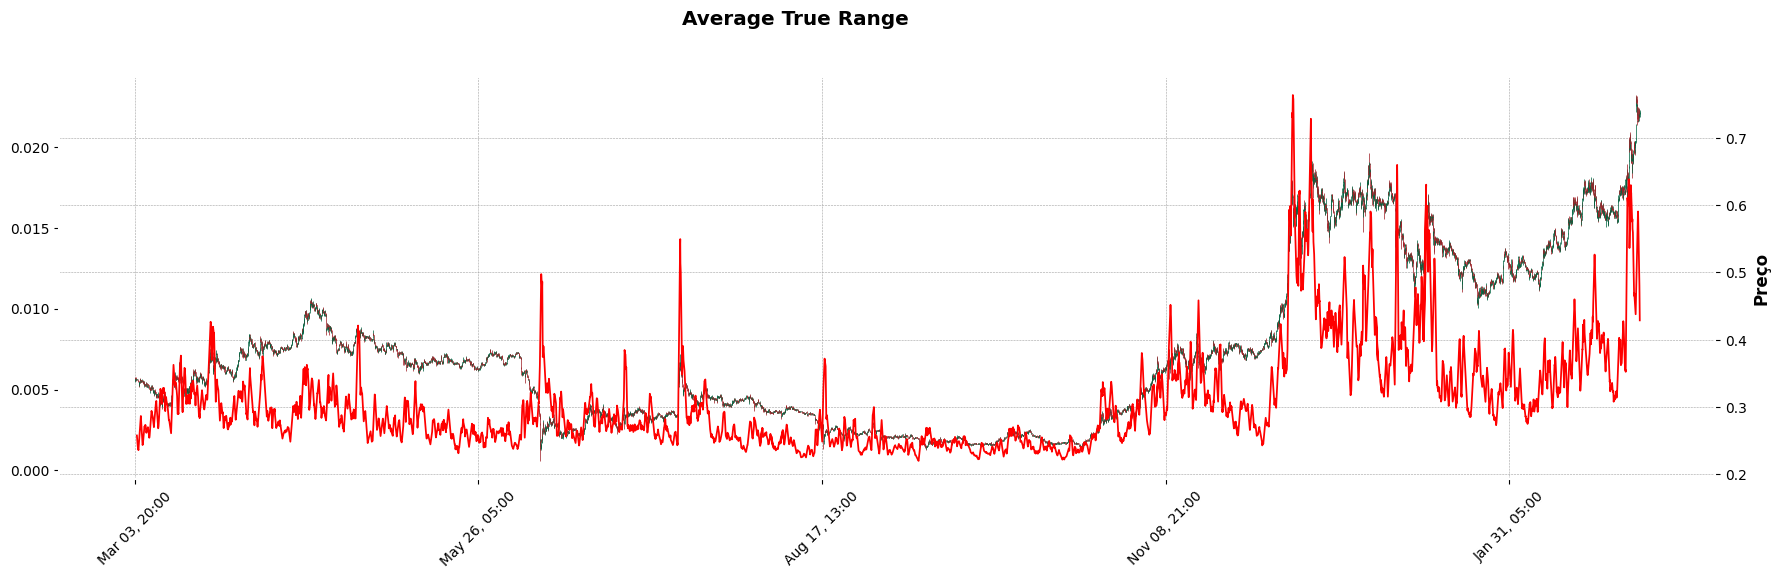

In [20]:
apds = [
  mpf.make_addplot(df['ATR'], color='red'),
]

mpf.plot(df, style='charles', addplot=apds, figratio=(32,8), title='Average True Range', ylabel='Preço')

## Rate-of-Change (ROC)

In [21]:
n_month = 24 * 30
n_week = 24 * 7

df['ROC_1M'] = ((df['Close'] - df['Close'].shift(n_month)) / df['Close'].shift(n_month)) * 100
df['ROC_1W'] = ((df['Close'] - df['Close'].shift(n_week)) / df['Close'].shift(n_week)) * 100

c:\Python39\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


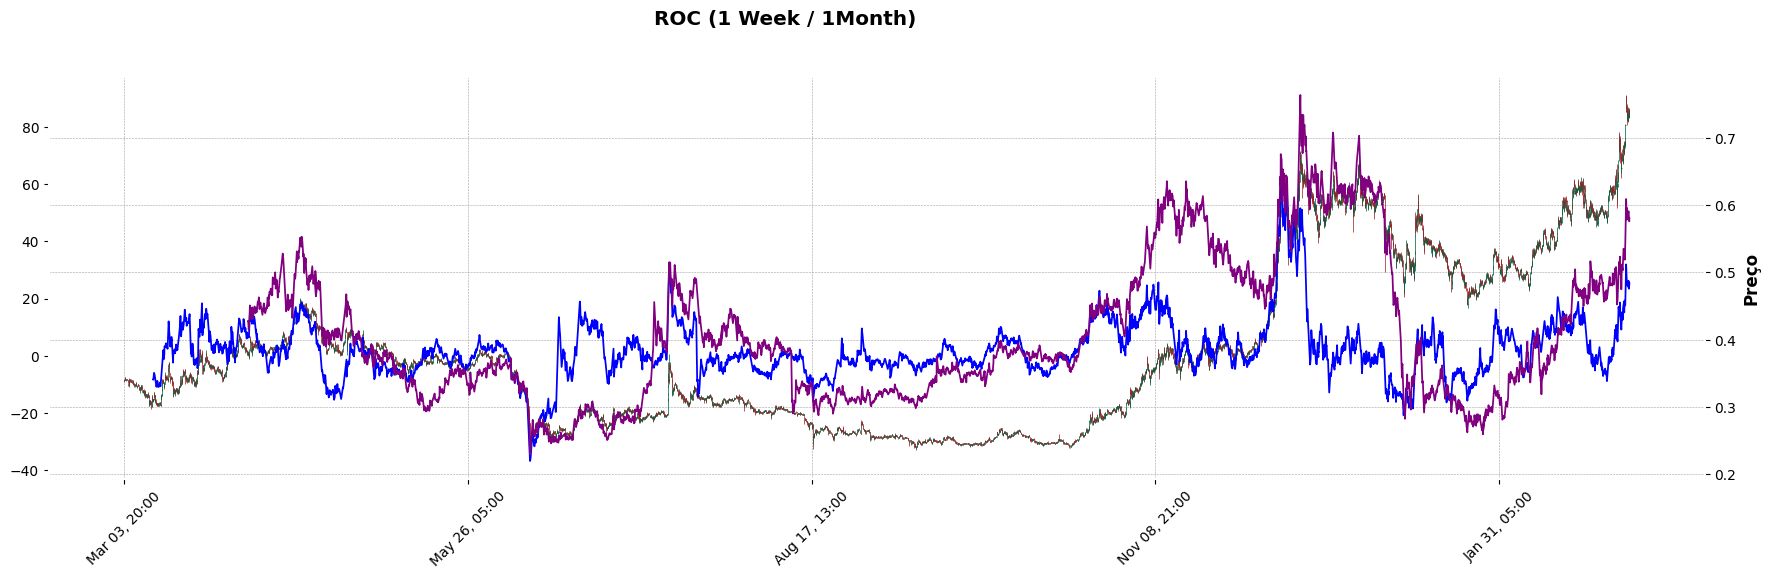

In [22]:
apds = [
  mpf.make_addplot(df['ROC_1W'], color='blue'),
  mpf.make_addplot(df['ROC_1M'], color='purple'),
]

mpf.plot(df, style='charles', addplot=apds, figratio=(32,8), title='ROC (1 Week / 1Month)', ylabel='Preço')

## Williams %R

In [23]:
# Calculando o Williams %R
df['Highest_High'] = df['High'].rolling(window=periods).max()
df['Lowest_Low'] = df['Low'].rolling(window=periods).min()
df['Williams_%R'] = ((df['Highest_High'] - df['Close']) / (df['Highest_High'] - df['Lowest_Low'])) * -100

c:\Python39\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


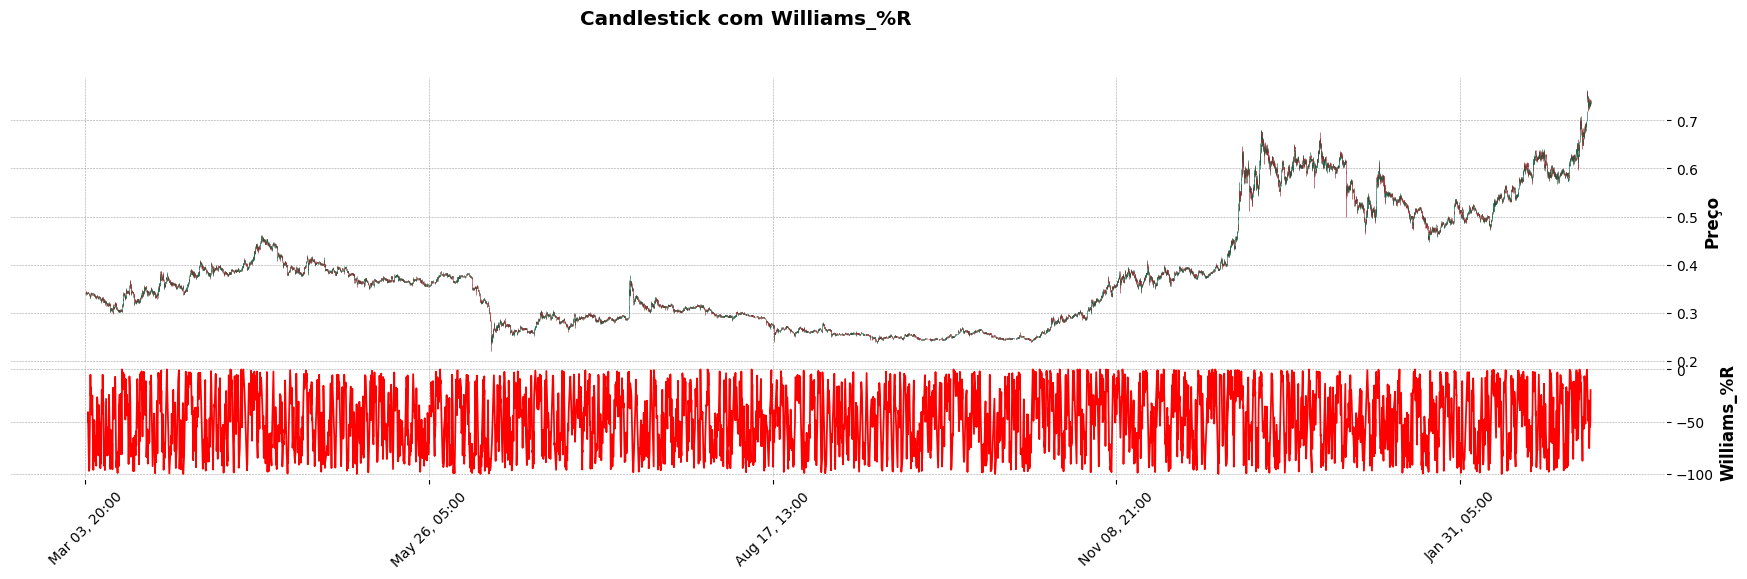

In [24]:
apdict = mpf.make_addplot(df['Williams_%R'], panel=1, color='r', ylabel='Williams_%R')

mpf.plot(df, type='candle', style='charles', addplot=apdict, figratio=(32,8), title='Candlestick com Williams_%R', ylabel='Preço')

## Stochastic Oscillator

In [25]:
# Definindo o período para o cálculo das linhas %K e %D
n = 14  # Período comum para %K
d_n = 3  # Período comum para a média móvel %D

# Calculando a linha %K
df['Highest_High'] = df['High'].rolling(window=n).max()
df['Lowest_Low'] = df['Low'].rolling(window=n).min()
df['%K'] = ((df['Close'] - df['Lowest_Low']) / (df['Highest_High'] - df['Lowest_Low'])) * 100

# Calculando a linha %D como a média móvel simples de %K
df['%D'] = df['%K'].rolling(window=d_n).mean()

c:\Python39\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


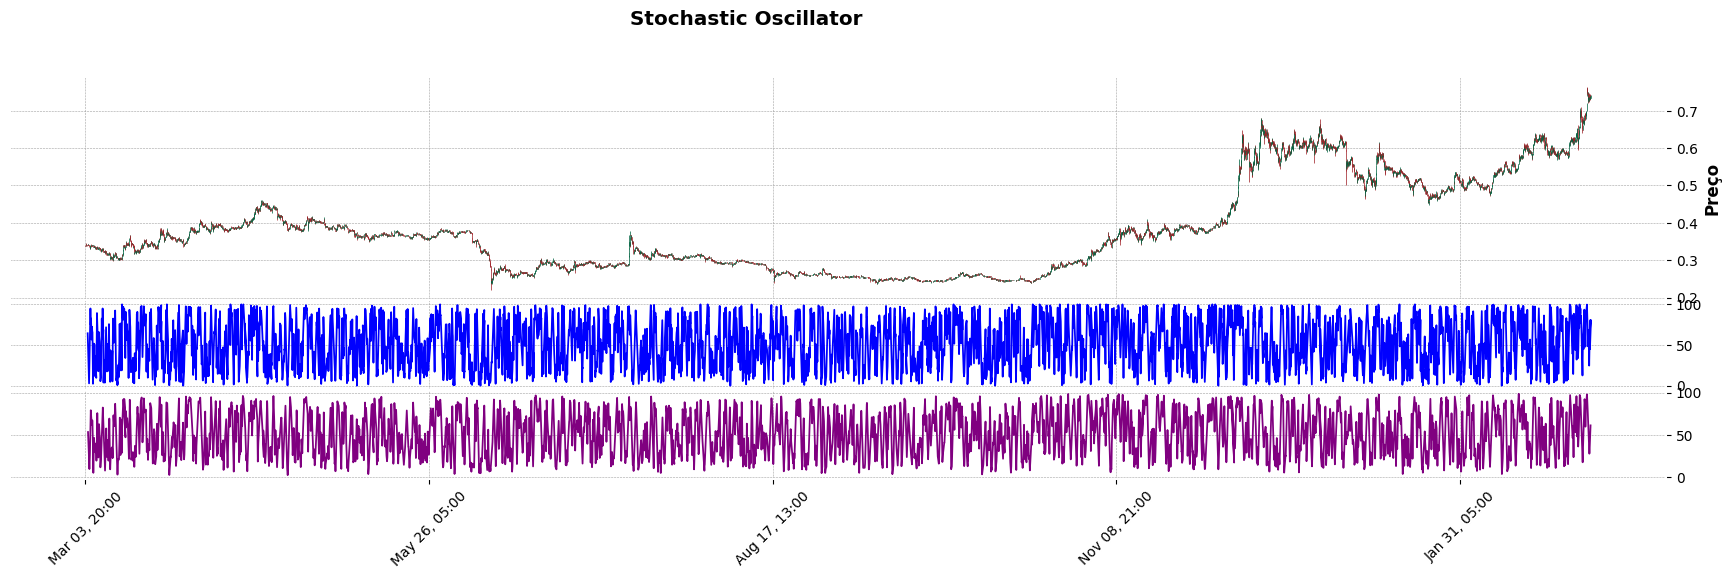

In [26]:
apds = [
  mpf.make_addplot(df['%K'], color='blue', panel=1),
  mpf.make_addplot(df['%D'], color='purple', panel=2),
]

mpf.plot(df, style='charles', addplot=apds, figratio=(32,8), title='Stochastic Oscillator', ylabel='Preço')

## Money Flow Index

In [27]:
# Calculando o preço típico
df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

# Calculando o fluxo de dinheiro
df['Money_Flow'] = df['Typical_Price'] * df['Volume USDT']

# Identificando fluxos positivos e negativos
df['Positive_Flow'] = df['Money_Flow'].where(df['Typical_Price'] > df['Typical_Price'].shift(), 0)
df['Negative_Flow'] = df['Money_Flow'].where(df['Typical_Price'] < df['Typical_Price'].shift(), 0)

# Definindo o período para o cálculo do MFI, geralmente 14 dias
period = 14

# Calculando a razão de fluxo de dinheiro
df['Money_Flow_Ratio'] = (df['Positive_Flow'].rolling(window=period).sum() / 
                          df['Negative_Flow'].rolling(window=period).sum())

# Calculando o MFI
df['MFI'] = 100 - (100 / (1 + df['Money_Flow_Ratio']))

c:\Python39\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


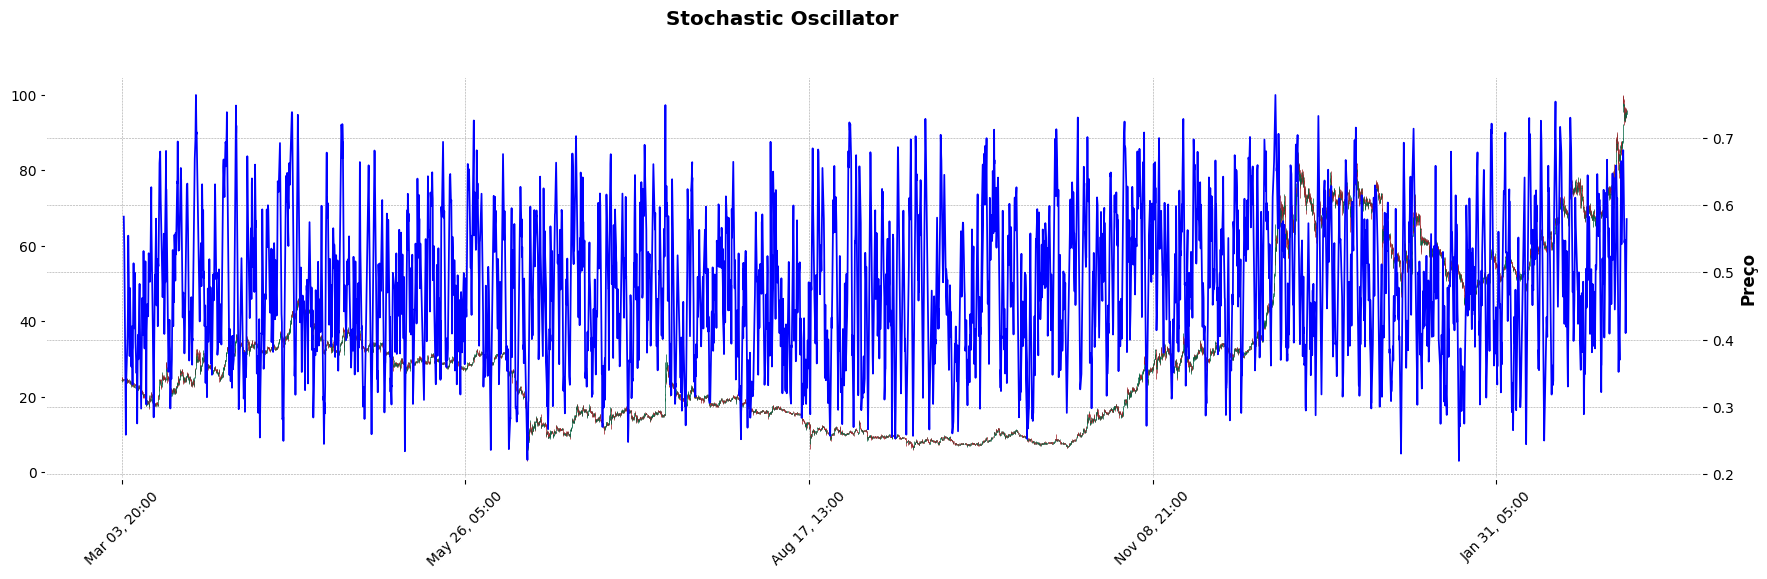

In [28]:
apds = [
  mpf.make_addplot(df['MFI'], color='blue'),
]

mpf.plot(df, style='charles', addplot=apds, figratio=(32,8), title='Stochastic Oscillator', ylabel='Preço')

In [29]:
df.head()

,Open,High,Low,Close,Volume ADA,Volume USDT,tradecount,RSI,SMA,SD,...,Lowest_Low,Williams_%R,%K,%D,Typical_Price,Money_Flow,Positive_Flow,Negative_Flow,Money_Flow_Ratio,MFI
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-03 20:00:00,0.3396,0.3405,0.3383,0.3390,1600503.8,5.434495e+05,1864,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.339267,184374.288777,0.000000,0.0,NaN,NaN
2023-03-03 21:00:00,0.3390,0.3413,0.3372,0.3403,3211643.4,1.089974e+06,3489,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.339600,370155.247618,370155.247618,0.0,NaN,NaN
2023-03-03 22:00:00,0.3404,0.3429,0.3402,0.3425,3519971.7,1.201852e+06,3191,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.341867,410873.168382,410873.168382,0.0,NaN,NaN
2023-03-03 23:00:00,0.3425,0.3437,0.3398,0.3431,6717843.0,2.296459e+06,5571,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.342200,785848.127014,785848.127014,0.0,NaN,NaN
2023-03-04 00:00:00,0.3431,0.3446,0.3422,0.3430,3580949.6,1.229634e+06,3109,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.343267,422092.223898,422092.223898,0.0,NaN,NaN


In [30]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [31]:
df['Expected Return'] = df['Close'].shift(-1) / df['Close'] - 1
                    
split_point = int(len(df) * 0.7)

X = df.loc[:, df.columns != 'Expected Return']
Y = df['Expected Return'].apply(lambda x: 1 if x > 0 else 0) # Buy

x_train = X[:split_point]
x_test = X[split_point:]

y_train = Y[:split_point]
y_test = Y[split_point:]

selector = SelectKBest(score_func=f_classif, k=11)

x_train2 = selector.fit_transform(x_train, y_train)
x_test2 = selector.transform(x_test)

model = lgb.LGBMClassifier(
    learning_rate=0.1,
    n_estimators=150,
    num_leaves=31,
    random_state=42,
)

model.fit(x_train2, y_train)

prediction = (model.predict_proba(x_test2)[:, 1] >= 0.4).astype(int)

[LightGBM] [Info] Number of positive: 2979, number of negative: 3153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 6132, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485812 -> initscore=-0.056767
[LightGBM] [Info] Start training from score -0.056767


In [41]:
# joblib.dump(model, 'model.pkl')

['model.pkl']

In [32]:
df.columns[np.where(selector.get_support())[0]]

Index(['Volume ADA', 'Volume USDT', 'tradecount', 'RSI', 'MACD', 'Williams_%R',
       '%K', '%D', 'Money_Flow', 'Negative_Flow', 'MFI'],
      dtype='object')

In [33]:
x_test['Prediction'] = prediction

C:\Users\Vlademir\AppData\Local\Temp\ipykernel_15432\107671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['Prediction'] = prediction


In [34]:
x_test['Expected Return'] = x_test['Close'].shift(-1) / x_test['Close'] - 1

C:\Users\Vlademir\AppData\Local\Temp\ipykernel_15432\3050993691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['Expected Return'] = x_test['Close'].shift(-1) / x_test['Close'] - 1


In [35]:
x_test[x_test['Prediction'] == 1]['Expected Return'].sum()

1.273315108550373

In [36]:
alavancagem = 4

history = [200]

for _, row in x_test.iterrows():
  if row['Prediction'] == 1:
    history.append(history[-1] * (1 + row['Expected Return'] * alavancagem)) # juros compostos & alavancagem

In [37]:
history[-1] / history[0] - 1

48.27137087277021

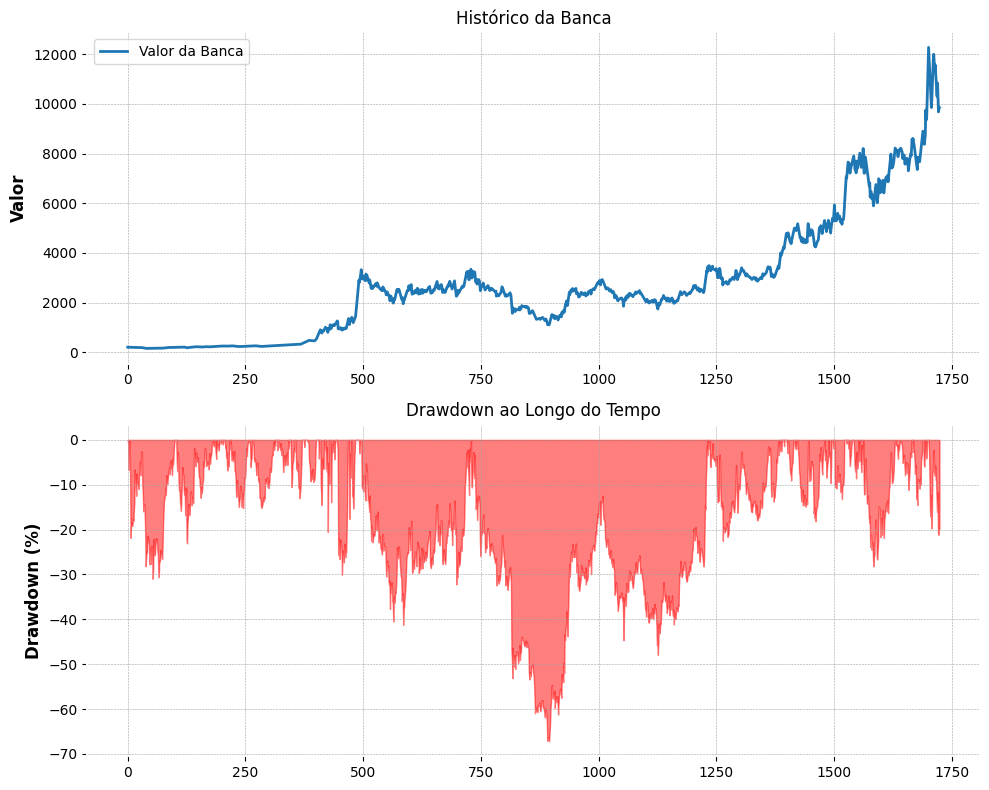

Maior queda: -67.16%
Maior tempo sem lucro: 502 entradas


In [38]:
# Calculando o drawdown máximo e o time under water
def calculate_drawdowns(history):
    history = np.array(history)
    peaks = np.maximum.accumulate(history)
    drawdowns = 100 * (history - peaks) / peaks
    return drawdowns

def calculate_time_under_water(drawdowns):
    return np.sum(drawdowns < 0)

drawdowns = calculate_drawdowns(history)
max_drawdown = np.min(drawdowns)
time_under_water = calculate_time_under_water(drawdowns)

def calculate_longest_time_under_water(drawdowns):
    """Calcula o maior período 'under water' (tempo em que o valor está abaixo do pico)."""
    in_drawdown = drawdowns < 0
    longest_time = 0
    current_time = 0

    for is_under_water in in_drawdown:
        if is_under_water:
            current_time += 1
            longest_time = max(longest_time, current_time)
        else:
            current_time = 0

    return longest_time

# Calculando o maior tempo under water
longest_time_under_water = calculate_longest_time_under_water(drawdowns)

# Criando gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico do histórico da banca
ax1.plot(history, label='Valor da Banca')
ax1.set_title('Histórico da Banca')
ax1.set_ylabel('Valor')
ax1.legend()

# Gráfico do Drawdown
ax2.fill_between(range(len(history)), drawdowns, color='red', alpha=0.5)
ax2.set_title('Drawdown ao Longo do Tempo')
ax2.set_ylabel('Drawdown (%)')

plt.tight_layout()
plt.show()

print('Maior queda: {:.2f}%'.format(max_drawdown))
print('Maior tempo sem lucro: {} entradas'.format(longest_time_under_water))

In [39]:
# # RODOU EM 1H

# def calculate_drawdowns(history):
#     history = np.array(history)
#     peaks = np.maximum.accumulate(history)
#     drawdowns = 100 * (history - peaks) / peaks
#     return drawdowns

# scores = []

# for n_estimators in range(50, 200, 50): 
#     print(n_estimators)

#     for num_leaves in [5, 20, 31]:
#         for learning_rate in [0.05, 0.1, 0.2]:
#             for k in range(1, len(df.columns)):
#                 for threshold in np.arange(0.35, 0.65, 0.05):
#                     df['Expected Return'] = df['Close'].shift(-1) / df['Close'] - 1
                    
#                     split_point = int(len(df) * 0.7)
                    
#                     X = df.loc[:, df.columns != 'Expected Return']
#                     Y = df['Expected Return'].apply(lambda x: 1 if x > 0 else 0) # Buy
                    
#                     x_train = X[:split_point]
#                     x_test = X[split_point:]
                    
#                     y_train = Y[:split_point]
#                     y_test = Y[split_point:]
                    
#                     selector = SelectKBest(score_func=f_classif, k=k)

#                     x_train2 = selector.fit_transform(x_train, y_train)
#                     x_test2 = selector.transform(x_test)

#                     model = lgb.LGBMClassifier(
#                         learning_rate=learning_rate,
#                         n_estimators=n_estimators,
#                         num_leaves=num_leaves,
#                         random_state=42,
#                     )

#                     model.fit(x_train2, y_train)

#                     # prediction = model.predict(x_test2)
#                     prediction = (model.predict_proba(x_test2)[:, 1] >= threshold).astype(int)

#                     x_test['Expected Return'] = x_test['Close'].shift(-1) / x_test['Close'] - 1
#                     x_test['Prediction'] = prediction

#                     history_1 = [1]
#                     history_0 = [1]

#                     for _, row in x_test.iterrows():
#                         if row['Prediction'] == 1:
#                             history_1.append(history_1[-1] * (1 + row['Expected Return']))
#                         else:
#                             history_0.append(history_0[-1] * (1 + row['Expected Return'] * -1)) # errei aqui sou deu valor nan

#                     max_drawdown_1 = np.min(calculate_drawdowns(history_1))
#                     max_drawdown_0 = np.min(calculate_drawdowns(history_0))

#                     profit_1 = x_test[x_test['Prediction'] == 1]['Expected Return'].sum()
#                     profit_0 = x_test[x_test['Prediction'] == 0]['Expected Return'].sum() * -1

#                     scores.append([
#                         n_estimators,
#                         num_leaves,
#                         learning_rate,
#                         k,
#                         threshold,
#                         profit_1,
#                         max_drawdown_1,
#                         profit_0,
#                         max_drawdown_0
#                     ])

# columns = [
#     'n_estimators',
#     'num_leaves',
#     'learning_rate',
#     'k',
#     'threshold',
#     'profit_1',
#     'max_drawdown_1',
#     'profit_0',
#     'max_drawdown_0'
# ]

# df_scores = pd.DataFrame(scores, columns=columns)
# df_scores.to_csv('70-30 LGBM Drawdown.csv', index=False)